In [12]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("housing.csv")
df.head()
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]


num_features = ["longitude", "latitude", "housing_median_age", 
                "total_rooms", "total_bedrooms", "population", 
                "households", "median_income", "rooms_per_household", 
                "bedrooms_per_room", "population_per_household"]
cat_features = ["ocean_proximity"]


numeric = Pipeline([("imputer", SimpleImputer(strategy= "median")), 
                    ("scaler", StandardScaler())])

categorical = Pipeline([("imputer", SimpleImputer(strategy = "most_frequent")), 
                        ("ohe", OneHotEncoder(handle_unknown= "ignore" ))])


preprossesor = ColumnTransformer([("num", numeric, num_features), 
                                  ("cat", categorical, cat_features)])

X = df[num_features + cat_features]
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

clf = Pipeline([("preprossesor", preprossesor), ("model", LinearRegression())])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("r2_score:", r2_score(y_test, y_pred))










mean_squared_error: 4778547424.025956
mean_absolute_error: 49645.49244453642
r2_score: 0.635339233523819


In [18]:
candidates = {
    "linreg": LinearRegression(),
    "tree": DecisionTreeRegressor(random_state=42),
    "rf": RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
}

for name, base_model in candidates.items():
    model = Pipeline([("prep", preprossesor), ("model", base_model)])
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    print(name, scores.mean(), "±", scores.std())

linreg 0.572558432796427 ± 0.0724588226502527
tree 0.2563080327118026 ± 0.2663293887141278
rf 0.5975706840708781 ± 0.13889562095517466


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Suchraum definieren
search_space = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 10),
    "model__min_samples_split": randint(2, 10)
}

# RandomizedSearchCV Setup
search = RandomizedSearchCV(
    Pipeline([
        ("prep", preprossesor),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    param_distributions=search_space,
    n_iter=10,
    cv=3,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Training / Suche starten
search.fit(X_train, y_train)

# Beste Ergebnisse ausgeben
print("Best Parameters:", search.best_params_)
print("CV Best Score:", search.best_score_)






Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__max_depth': 9, 'model__min_samples_split': 5, 'model__n_estimators': 142}
CV Best Score: 0.7783944193092465


In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Bestes Modell aus RandomizedSearchCV nehmen
best_model = search.best_estimator_

# Testdaten vorhersagen
y_pred = best_model.predict(X_test)

# Evaluation auf Testdaten
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Test R²: 0.7699667632790339
Test MSE: 3014376186.9296813
Test MAE: 36813.48642551339


In [30]:
from sklearn.model_selection import GridSearchCV

# Best params aus RandomizedSearchCV
best_params = search.best_params_

param_grid = {
    "model__n_estimators": [
        best_params["model__n_estimators"] - 10,
        best_params["model__n_estimators"],
        best_params["model__n_estimators"] + 10,
    ],
    "model__max_depth": [
        best_params["model__max_depth"] - 1,
        best_params["model__max_depth"],
        best_params["model__max_depth"] + 1,
    ],
    "model__min_samples_split": [
        best_params["model__min_samples_split"],
    
    ]
}

grid_search = GridSearchCV(
    Pipeline([
        ("prep", preprossesor),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)


print(" Best Grid Params:", grid_search.best_params_)
print(" Best Grid CV Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_



Fitting 3 folds for each of 9 candidates, totalling 27 fits
 Best Grid Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 142}
 Best Grid CV Score: 0.787643680886018


In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))


Test R²: 0.7821309302572577
Test MAE: 35501.07415780297
Test MSE: 2854975850.718824


In [ ]:
'''import joblib
from flask import Flask, request, jsonify
import pandas as pd

joblib.dump(best_model, "housing_model.pkl")

app = Flask(__name__)
model = joblib.load("housing_model.pkl")

@app.route("/predict", methods=["POST"])
def predict():
    payload = request.get_json()
    df = pd.DataFrame([payload])
    pred = model.predict(df)[0]
    return jsonify({"prediction": float(pred)})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=8000)
'''


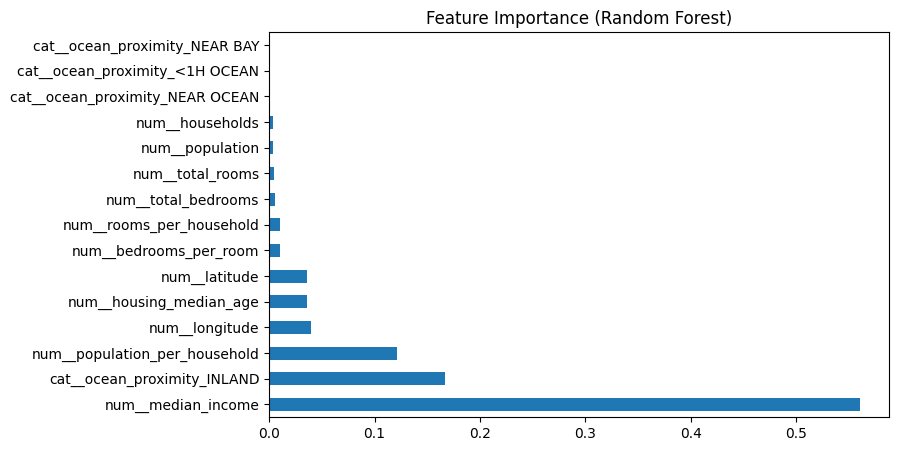

In [15]:
import matplotlib.pyplot as plt

importances = best_model.named_steps["model"].feature_importances_
features_names = best_model.named_steps["prep"].get_feature_names_out()
feat_imp = pd.Series(importances, index= features_names).sort_values(ascending=False)
feat_imp.head(15).plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance (Random Forest)")
plt.show()

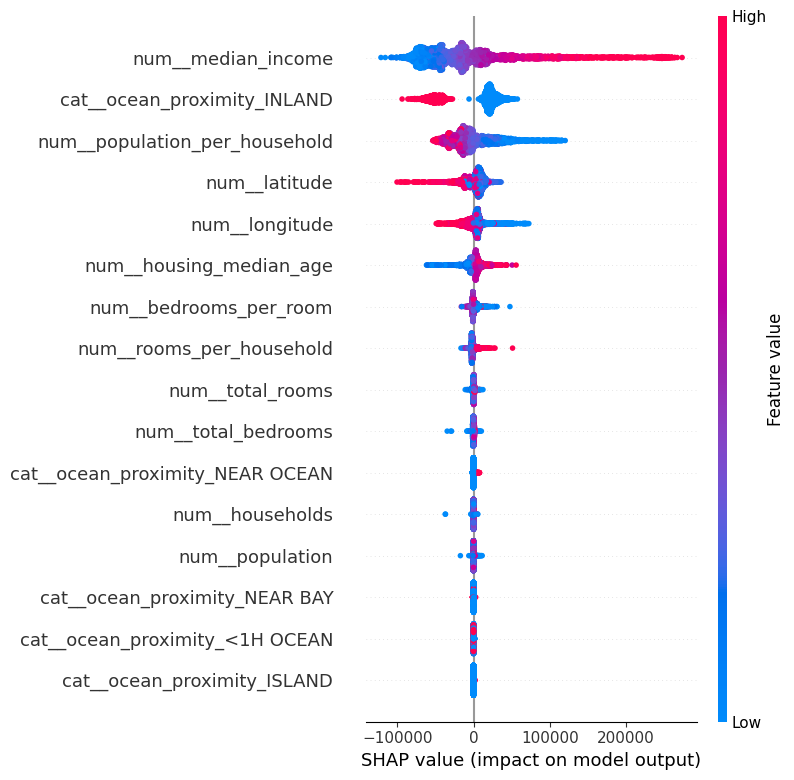

In [31]:
import shap

# 1. Hole das trainierte Modell und Preprocessor aus deiner Pipeline
model = best_model.named_steps["model"]
preprocessor = best_model.named_steps["prep"]

# 2. Wandle X_test in die transformierte Form um
X_test_transformed = preprocessor.transform(X_test)

# 3. Erstelle den SHAP-Explainer für das Baum-Modell
explainer = shap.TreeExplainer(model)

# 4. Berechne SHAP-Werte auf transformierten Features
shap_values = explainer.shap_values(X_test_transformed)

# 5. Hole die Feature-Namen nach dem Preprocessing
feature_names = preprocessor.get_feature_names_out()

# 6. Visualisierung
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


In [23]:
import joblib
joblib.dump(best_model, "housing_pipeline.pkl")




['housing_pipeline.pkl']